In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
from sklearn.cluster import MeanShift
from sklearn.datasets.samples_generator import make_blobs
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools as it
import sklearn as sk
from pandas import read_csv, DataFrame
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data
from __future__ import division, print_function
import warnings
%matplotlib inline
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model

warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [4]:
#Считываем данные 
 
df2015 = pd.read_csv("2015.csv")
df2016 = pd.read_csv("2016.csv")
df2017 = pd.read_csv("2017.csv")
df2018 = pd.read_csv("2018.csv")
df2019 = pd.read_csv("2019.csv")

df2019.head(100)

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298
...,...,...,...,...,...,...,...,...,...
95,96,Cameroon,5.044,0.549,0.910,0.331,0.381,0.187,0.037
96,97,Bulgaria,5.011,1.092,1.513,0.815,0.311,0.081,0.004
97,98,Ghana,4.996,0.611,0.868,0.486,0.381,0.245,0.040
98,99,Ivory Coast,4.944,0.569,0.808,0.232,0.352,0.154,0.090


In [3]:
#Соединяем данные в один датасет

#Удаляем ненужные столбцы в датасетах
df2015_figures = df2015.drop(['Country','Region','Standard Error','Dystopia Residual','Happiness Rank'], axis=1)
df2016_figures = df2016.drop(['Country','Region','Lower Confidence Interval','Upper Confidence Interval','Dystopia Residual','Happiness Rank'], axis=1)
df2017_figures = df2017.drop(['Country','Happiness.Rank','Whisker.high','Whisker.low','Dystopia.Residual'], axis=1)
df2018_figures = df2018.drop(['Country or region', 'Overall rank'], axis=1)
df2019_figures = df2019.drop(['Country or region', 'Overall rank'], axis=1)

#Приводим названия столбцов к одному виду
df2015_figures = df2015_figures[['Happiness Score','Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Generosity', 'Trust (Government Corruption)']]
df2016_figures = df2016_figures[['Happiness Score','Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)', 'Freedom', 'Generosity', 'Trust (Government Corruption)']]
df2015_figures.rename(columns={'Happiness Score': 'Score', 'Economy (GDP per Capita)': 'GDP per capita', 'Family': 'Social support', 'Health (Life Expectancy)': 'Healthy life expectancy', 'Freedom': 'Freedom to make life choices','Trust (Government Corruption)': 'Perceptions of corruption'}, inplace=True)
df2016_figures.rename(columns={'Happiness Score': 'Score', 'Economy (GDP per Capita)': 'GDP per capita', 'Family': 'Social support', 'Health (Life Expectancy)': 'Healthy life expectancy', 'Freedom': 'Freedom to make life choices','Trust (Government Corruption)': 'Perceptions of corruption'}, inplace=True)
df2017_figures.rename(columns={'Happiness.Score': 'Score', 'Economy..GDP.per.Capita.': 'GDP per capita', 'Family': 'Social support', 'Health..Life.Expectancy.': 'Healthy life expectancy', 'Freedom': 'Freedom to make life choices','Trust..Government.Corruption.': 'Perceptions of corruption'}, inplace=True)

#Соединяем в один датасет
df_all = df2019_figures.append(df2018_figures, ignore_index=True)
df_all = df_all.append(df2017_figures, ignore_index = True)
df_all = df_all.append(df2016_figures, ignore_index = True)
df_all = df_all.append(df2015_figures, ignore_index = True)

#Сортируем по столбцу Score
df_all = df_all.sort_values(by=['Score'], ascending=False,ignore_index = True)

df_all.head(1400)

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,7.769,1.340000,1.587000,0.986000,0.596000,0.153000,0.393000
1,7.632,1.305000,1.592000,0.874000,0.681000,0.202000,0.393000
2,7.600,1.383000,1.573000,0.996000,0.592000,0.252000,0.410000
3,7.594,1.456000,1.582000,0.861000,0.686000,0.286000,0.340000
4,7.587,1.396510,1.349510,0.941430,0.665570,0.296780,0.419780
...,...,...,...,...,...,...,...
777,2.905,0.015300,0.415870,0.223960,0.118500,0.197270,0.100620
778,2.905,0.091623,0.629794,0.151611,0.059901,0.204435,0.084148
779,2.853,0.306000,0.575000,0.295000,0.010000,0.202000,0.091000
780,2.839,0.208680,0.139950,0.284430,0.364530,0.166810,0.107310


***Разведочный анализ***

In [4]:
ScoreYears = pd.DataFrame([['2015', df2015_figures['Score'].mean()], ['2016', df2016_figures['Score'].mean()], ['2017', df2017_figures['Score'].mean()],  ['2018', df2018_figures['Score'].mean()],  ['2019', df2019_figures['Score'].mean()]], columns=['Years', 'value'])
ScoreYears.set_index('Years', inplace=True)
print(ScoreYears)  

          value
Years          
2015   5.375734
2016   5.382185
2017   5.354019
2018   5.375917
2019   5.407096


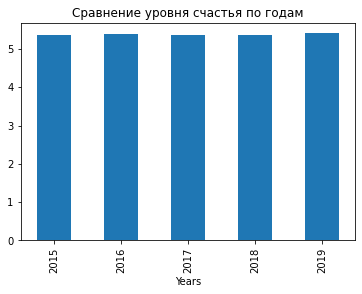

In [5]:
ScoreYears.value.plot(kind='bar', title='Сравнение уровня счастья по годам')

#Исходя из графика, можно сделать вывод, что уровень счастья в 2017-ом году был наименьшим, а в 2019-ом достиг максимального значения. Также мы видим, что измнения среднего значения Score незначительны

In [6]:
#Проверяем есть ли NaN значения в столбцах
df_all.isnull().values.any()

True

In [7]:
#Удаляем строки, где есть хотя бы одно значение NaN
df_all = df_all.dropna()
df_all.head(1400)

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,7.769,1.340000,1.587000,0.986000,0.596000,0.153000,0.393000
1,7.632,1.305000,1.592000,0.874000,0.681000,0.202000,0.393000
2,7.600,1.383000,1.573000,0.996000,0.592000,0.252000,0.410000
3,7.594,1.456000,1.582000,0.861000,0.686000,0.286000,0.340000
4,7.587,1.396510,1.349510,0.941430,0.665570,0.296780,0.419780
...,...,...,...,...,...,...,...
777,2.905,0.015300,0.415870,0.223960,0.118500,0.197270,0.100620
778,2.905,0.091623,0.629794,0.151611,0.059901,0.204435,0.084148
779,2.853,0.306000,0.575000,0.295000,0.010000,0.202000,0.091000
780,2.839,0.208680,0.139950,0.284430,0.364530,0.166810,0.107310


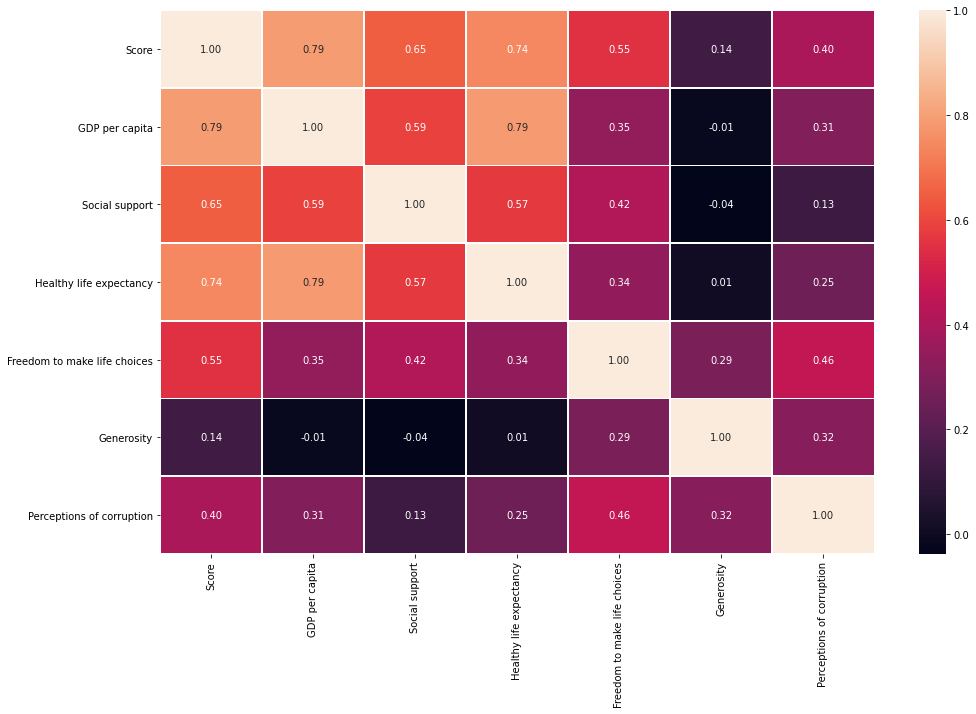

In [8]:
#Корреляционная матрица 
plt.subplots(figsize=(16, 10))
sns.heatmap(df_all.corr(), annot=True, linewidths=.6, fmt= '.2f')
plt.show()

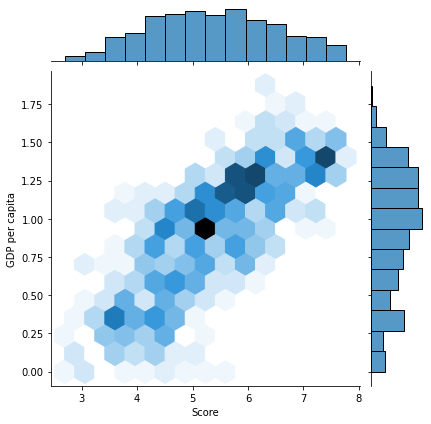

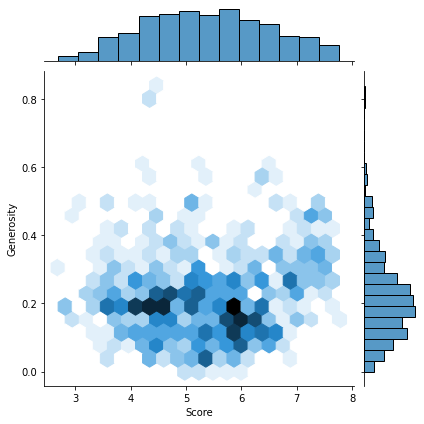

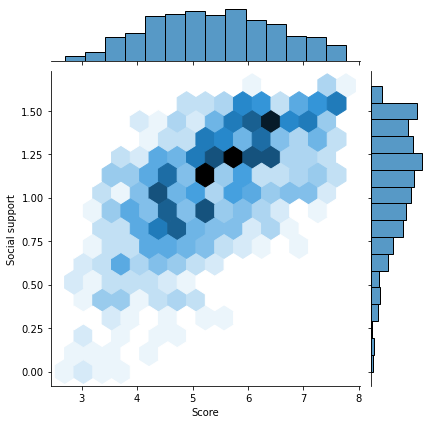

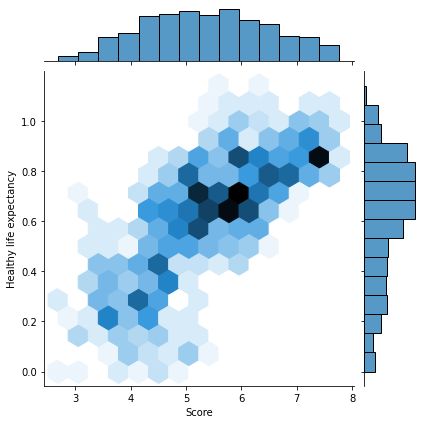

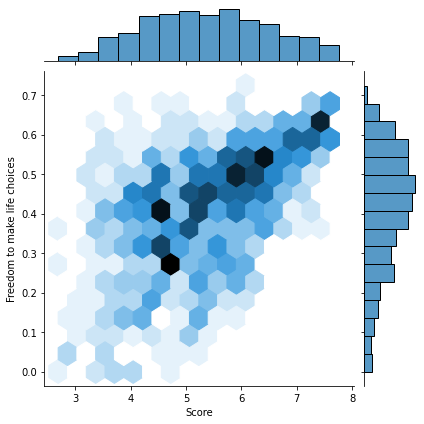

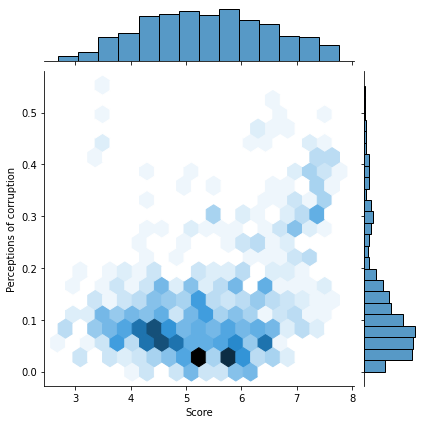

In [9]:
#График соотношения процента счастья к ВВП (Score vs GDP per capita)
sns.jointplot(x="Score", y="GDP per capita", data=df_all,  kind="hex")
#График соотношения процента счастья к щедрости (Score vs Generosity)
sns.jointplot(x="Score", y="Generosity", data=df_all,  kind="hex")
#График соотношения процента счастья к социальной поддержке (Score vs Social support)
sns.jointplot(x="Score", y="Social support", data=df_all,  kind="hex")
#График соотношения процента счастья к продолжительности жизни (Score vs Healthy life expectancy)
sns.jointplot(x="Score", y="Healthy life expectancy", data=df_all,  kind="hex")
#График соотношения процента счастья к свободе выбора (Score vs Freedom to make life choices)
sns.jointplot(x="Score", y="Freedom to make life choices", data=df_all,  kind="hex")
#График соотношения процента счастья к корррупции (Score vs Perceptions of corruption)
sns.jointplot(x="Score", y="Perceptions of corruption", data=df_all,  kind="hex")


plt.show()

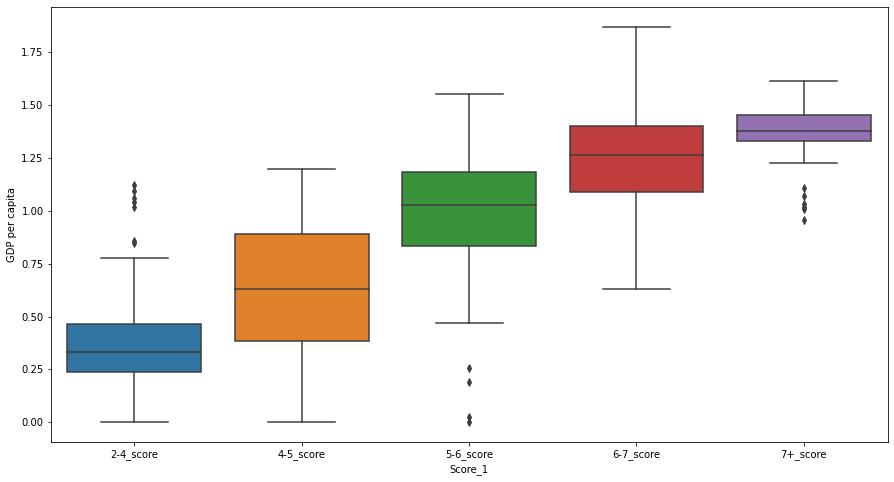

In [10]:
data2 = df_all.copy()
#Сортировка значений данных
data2['Score_1'] = pd.cut(data2['Score'], [2, 4, 5, 6, 7, 10], labels=['2-4_score','4-5_score', '5-6_score', '6-7_score', '7+_score'])
plt.figure(figsize=(15,8))
#Линейная диаграмма (или линейная диаграмма с усами) показывает распределение количественных данных таким образом, чтобы облегчить сравнение между переменными или между уровнями категориальной переменной
#Поле показывает квартили набора данных, в то время как усы расширяются, чтобы показать остальную часть распределения, 
#за исключением точек, которые определяются как “выбросы” с помощью метода, являющегося функцией межквартильного диапазона.
sns.boxplot(x="Score_1", y="GDP per capita", data=data2)
plt.show()

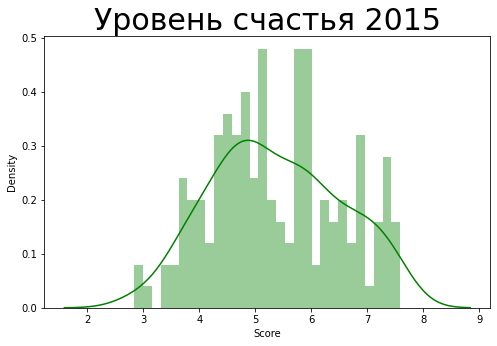

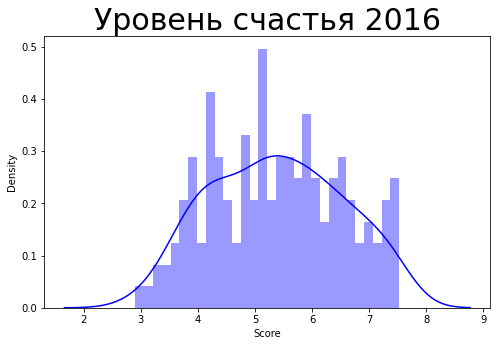

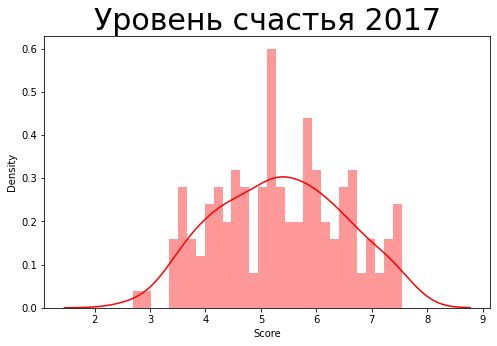

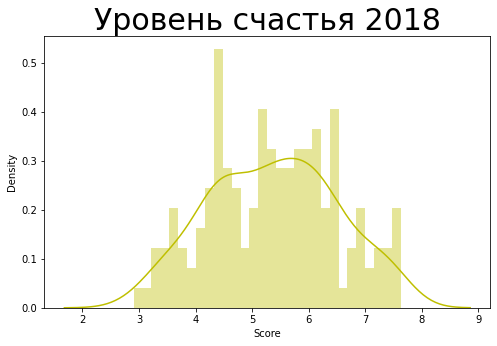

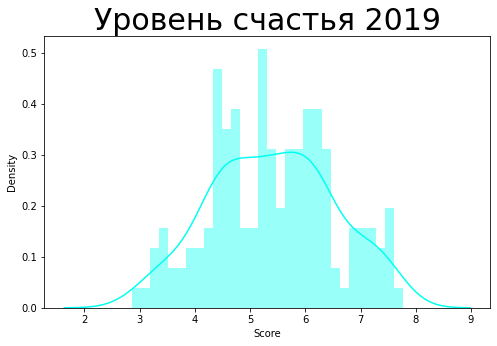

In [11]:
data15 = df2015_figures.copy()
data16 = df2016_figures.copy()
data17 = df2017_figures.copy()
data18 = df2018_figures.copy()
data19 = df2019_figures.copy()
#Графики показывают какое значение "Score" чаще всего встречалось
#в 2015 году
plt.figure(figsize=(8,5))
plt.title("Уровень счастья 2015",fontsize=30)
sns.distplot(data15['Score'], bins=30, color = "g")
#в 2016 году
plt.figure(figsize=(8,5))
plt.title("Уровень счастья 2016",fontsize=30)
sns.distplot(data16['Score'], bins=30, color = "b")
#в 2017 году
plt.figure(figsize=(8,5))
plt.title("Уровень счастья 2017",fontsize=30)
sns.distplot(data17['Score'], bins=30, color = "r")
#в 2018 году
plt.figure(figsize=(8,5))
plt.title("Уровень счастья 2018",fontsize=30)
sns.distplot(data18['Score'], bins=30, color = "y")
#в 2019 году
plt.figure(figsize=(8,5))
plt.title("Уровень счастья 2019",fontsize=30)
sns.distplot(data19['Score'], bins=30, color = "#00fff2")

plt.show()


***Регрессионый анализ***

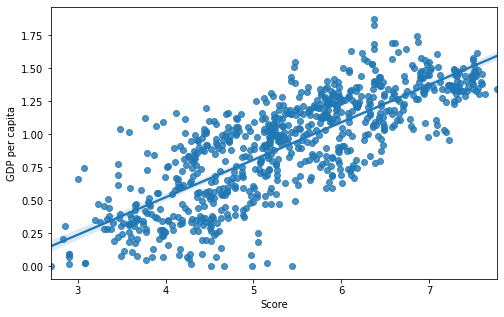

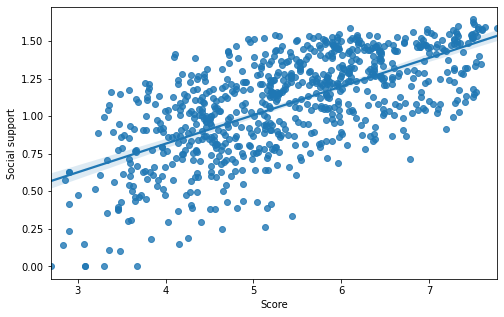

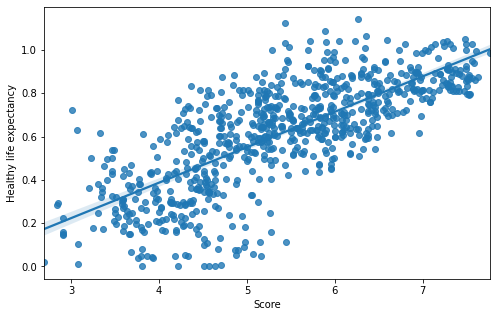

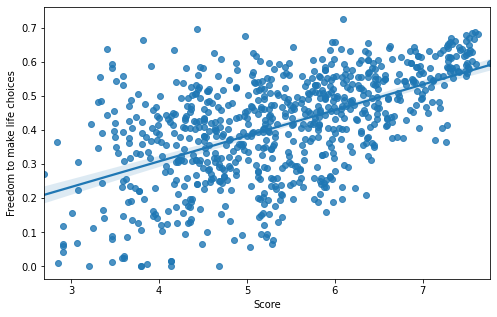

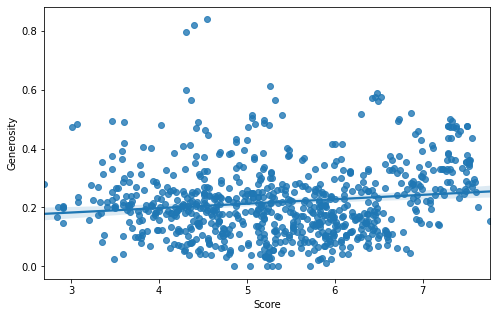

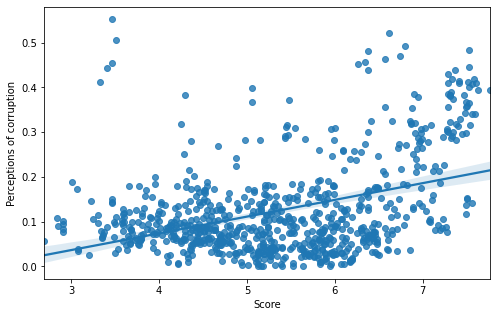

In [12]:
#Предварительно посмотрим какая величина имеет самое большое влияние на счет, путем рисования графиков линейной регрессии 

plt.figure(figsize=(8,5))
sns.regplot(x="Score", y="GDP per capita", data=df_all)

plt.figure(figsize=(8,5))
sns.regplot(x="Score", y="Social support", data=df_all)

plt.figure(figsize=(8,5))
sns.regplot(x="Score", y="Healthy life expectancy", data=df_all)

plt.figure(figsize=(8,5))
sns.regplot(x="Score", y="Freedom to make life choices", data=df_all)

plt.figure(figsize=(8,5))
sns.regplot(x="Score", y="Generosity", data=df_all)

plt.figure(figsize=(8,5))
sns.regplot(x="Score", y="Perceptions of corruption", data=df_all)

plt.show()
# На глаз ВВП имеет самое большее влияние. Проверим путем построения регрессионой модели

In [13]:
# Рассмотрим 4 типа регрессионных моделей и выберем лучшую, рассчитывая коэффициент R^2
# Получим Y
trg = df_all[['Score']]
# Получим зависимые заначения
trn = df_all.drop(['Score'], axis=1)
# Объявим все модели для дальнейшего их обучения
models = [LinearRegression(), # метод наименьших квадратов
	          RandomForestRegressor(n_estimators=100, max_features ='sqrt'), # случайный лес
	          KNeighborsRegressor(n_neighbors=6), # метод ближайших соседей
	          SVR(kernel='linear'), # метод опорных векторов с линейным ядром
          ]

# Разобьем данные на тестовую и обучающую выборки
Xtrain, Xtest, Ytrain, Ytest = train_test_split(trn, trg, test_size=0.4)

In [14]:
#создаем временные структуры
TestModels = DataFrame()
tmp = {}
#для каждой модели из списка
for model in models:
  #получаем имя модели
  m = str(model)
  tmp['Model'] = m[:m.index('(')]  
  #обучаем модель
  model.fit(Xtrain, Ytrain) 
  #вычисляем коэффициент детерминации
  tmp['R2_Y'] = r2_score(Ytest, model.predict(Xtest))
  #записываем данные и итоговый DataFrame
  TestModels = TestModels.append([tmp])
#делаем индекс по названию модели
TestModels.set_index('Model', inplace=True)
print(TestModels)  

                           R2_Y
Model                          
LinearRegression       0.751829
RandomForestRegressor  0.798619
KNeighborsRegressor    0.798941
SVR                    0.748415


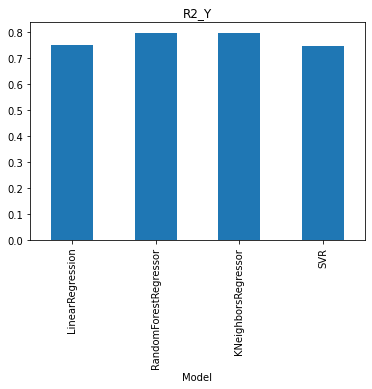

In [15]:
#Построим графики R^2 коэффициентов
TestModels.R2_Y.plot(kind='bar', title='R2_Y')

#Как мы видим из графика модель построенная методом случайных деревьев самая точная (R^2 = 0.840712)

In [16]:
# По новой обучим модель
model = models[1]
model.fit(Xtrain, Ytrain)

# Посмотрим как каждый фактор влиет на прогнозное значение Y
model.feature_importances_

# Как мы можем увидеть ВВП на душу населения и продолжительность жизни наиболее сильно влияют на оценку счастья (около 60%), 
# социальная поддержка и свобода жизненного выбора почти равнозначны (около 14%),
# а самое незначительное влияние у щедрости и коррупции (около 5% и 9% соответственно) 

array([0.31762467, 0.14642468, 0.27249249, 0.12599134, 0.05574382,
       0.081723  ])

***Кластеризация и построение деревьев решений***

In [17]:
# Произведем кластеризацию данных по методу k-mean для 2019 года
X = df2019_figures.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)

k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)
k_means.fit(X)
labels = k_means.labels_

df2019_figures["Class"] = labels
df2019_figures.head(5)

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Class
0,7.769,1.340,1.587,0.986,0.596,0.153,0.393,0
1,7.600,1.383,1.573,0.996,0.592,0.252,0.410,0
2,7.554,1.488,1.582,1.028,0.603,0.271,0.341,0
3,7.494,1.380,1.624,1.026,0.591,0.354,0.118,0
4,7.488,1.396,1.522,0.999,0.557,0.322,0.298,0


In [18]:
# Выведем средние данные класстеризации
df2019_figures.groupby("Class").mean()

# Как мы можем видеть алгоритм K-means разделил наши данные на 3 кластера. Попробуем разобраться по каким критериям производилось разделение
# К классу 0 присвоены страны в которых наивысшие показатели ВВП на душу населения, социальная поддержка, предполагаемая продолжительность жизни, свобода жизненного выбора, но в то же время средний показатель щедрости и наивысший показатель коррумпированности
# К классу 1 присвоены страны в которых средние показатели ВВП на душу населения, социальная поддержка, предполагаемая продолжительность жизни, свобода жизненного выбора, но в то же время низший показатель щедрости и низший показатель коррумпированности
# К классу 2 присвоены страны в которых низшие показатели ВВП на душу населения, социальная поддержка, предполагаемая продолжительность жизни, свобода жизненного выбора, но в то же время высший показатель щедрости и средний показатель коррумпированности

# Из чего можно сделать вывод, что для 2019 года ключевыми показателями являются:
# - ВВП на душу населения
# - социальная поддержка
# - предполагаемая продолжительность жизни
# - свобода жизненного выбора

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Class,,,,,,,
0,6.639864,1.352000,1.457955,0.969068,0.483545,0.206114,0.182750
1,4.251378,0.395089,0.867644,0.423111,0.320289,0.208333,0.098400
2,5.373746,0.954269,1.274343,0.768045,0.381373,0.155104,0.071418


In [19]:
# Теперь рассмотрим работу алгоритма для данных за 5 лет
X = df_all.values[:,1:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
k_means = KMeans(init = "k-means++", n_clusters = 3, n_init = 12)
k_means.fit(X)
labels = k_means.labels_

df_all["Class"] = labels
df_all.groupby("Class").mean()
# Как можно заметить класстеры были разбиты тем же самым образом
#Следует заметить, что средние показатели ВВП, соц.поддержки и предполагаемой продолжительности жизни в 2019 году достигла более высоких показателей, что говорит о том, что уровень жизни вырос
#Но свобода жизненного выбора, щедрость населения стала ниже. Также в 2019 году немного уменьшилась коррумпированность

,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
Class,,,,,,,
0,6.484946,1.329451,1.347781,0.836122,0.498556,0.237558,0.183704
1,4.141788,0.388352,0.745482,0.312042,0.339124,0.244801,0.114086
2,5.304256,0.930300,1.083670,0.632060,0.388352,0.185225,0.085151


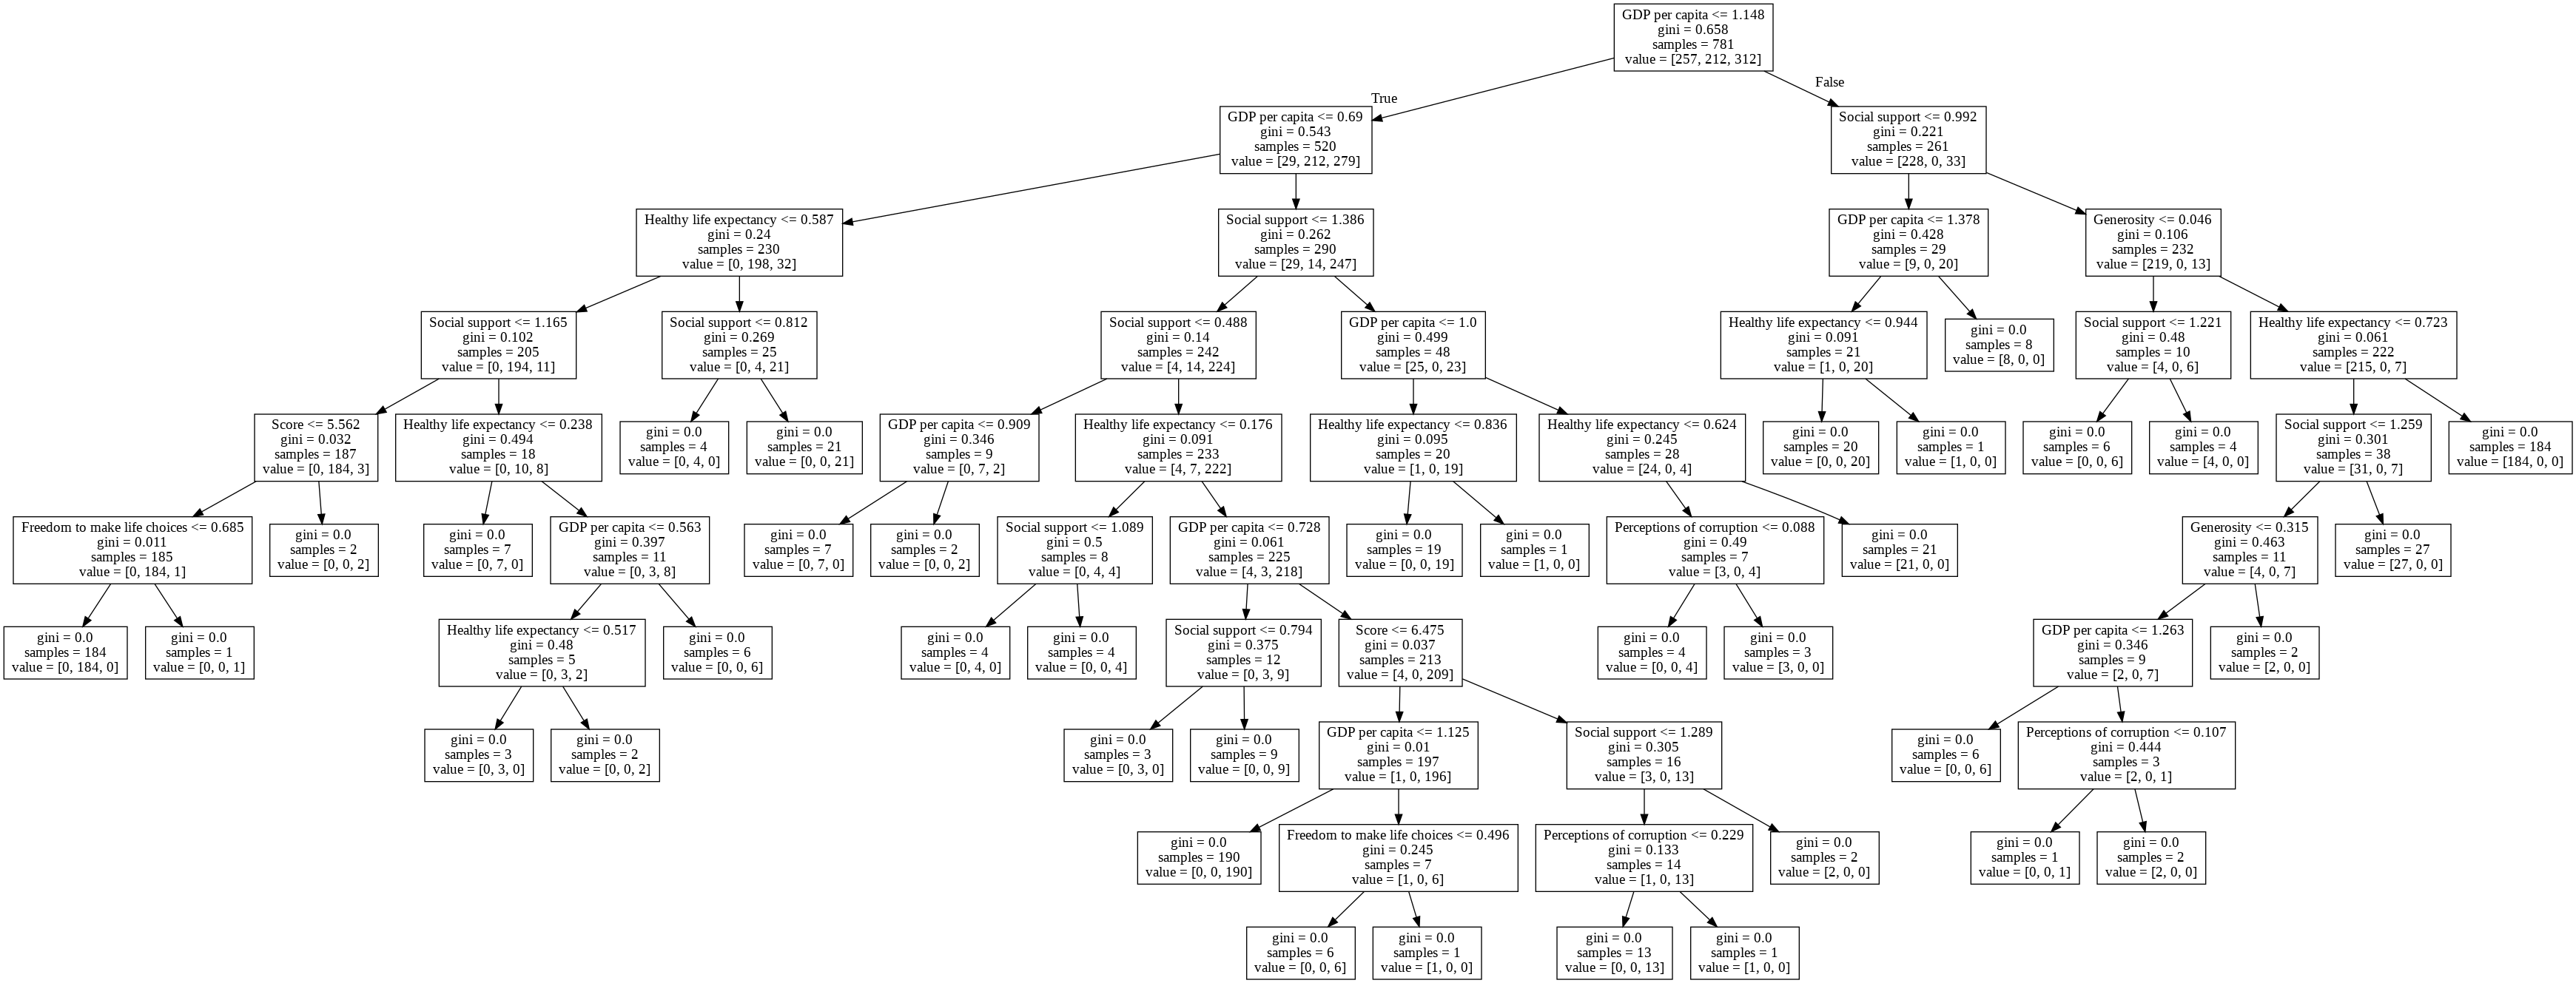

In [21]:
#Построение дерева решений для классов кластеризованных методом k-means
df_all.head()
age_sal_tree = DecisionTreeClassifier()
age_sal_tree.fit(df_all[['Score', 'GDP per capita','Social support','Healthy life expectancy','Freedom to make life choices','Generosity','Perceptions of corruption']].values, df_all['Class'].values);

dot_data = StringIO()
export_graphviz(age_sal_tree , out_file=dot_data, feature_names=['Score', 'GDP per capita','Social support','Healthy life expectancy','Freedom to make life choices','Generosity','Perceptions of corruption'])
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

***Создание и обучение RNN модели***


In [22]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM


def rearrange(ds, lb=2):
    X, Y = [], []
    for i in range(len(ds) - lb - 1):
        a = ds[i:(i + lb), 0]
        X.append(a)
        Y.append(ds[i + lb, 0])
    X = np.array(X)
    X = np.reshape(X, (X.shape[0], 1, 1))
    return X, np.array(Y)


def create_rnn():
    # создаём модель Sequential 
    model = Sequential()
    # добавляем входной слой из LSTM 
    model.add(LSTM(8, input_shape=(1, 1)))
    # и на выходе Dense слой 
    model.add(Dense(1))
    # метрика расчёта потерь -- MAE (Mean Absolute Error) 
    # метод оптимизации -- adam
    model.compile(loss='mae', optimizer='adam')
    return model

[[1.34 ]
 [1.587]
 [0.986]
 [0.596]
 [0.153]
 [0.393]
 [0.   ]
 [1.305]
 [1.592]
 [0.874]]
train_shape = (3675, 1), test_shape = (1225, 1)
X_train_size = (3673, 1, 1), Y_train_shape = (3673,)
Epoch 1/20
3673/3673 - 7s - loss: 0.1958 - val_loss: 0.1923
Epoch 2/20
3673/3673 - 4s - loss: 0.1923 - val_loss: 0.1971
Epoch 3/20
3673/3673 - 5s - loss: 0.1921 - val_loss: 0.1972
Epoch 4/20
3673/3673 - 5s - loss: 0.1920 - val_loss: 0.1984
Epoch 5/20
3673/3673 - 5s - loss: 0.1921 - val_loss: 0.1941
Epoch 6/20
3673/3673 - 5s - loss: 0.1918 - val_loss: 0.1995
Epoch 7/20
3673/3673 - 4s - loss: 0.1915 - val_loss: 0.1927
Epoch 8/20
3673/3673 - 5s - loss: 0.1915 - val_loss: 0.1967
Epoch 9/20
3673/3673 - 4s - loss: 0.1916 - val_loss: 0.1983
Epoch 10/20
3673/3673 - 4s - loss: 0.1916 - val_loss: 0.1948
Epoch 11/20
3673/3673 - 4s - loss: 0.1914 - val_loss: 0.1954
Epoch 12/20
3673/3673 - 5s - loss: 0.1912 - val_loss: 0.1979
Epoch 13/20
3673/3673 - 5s - loss: 0.1911 - val_loss: 0.1966
Epoch 14/20
3673/3673 - 

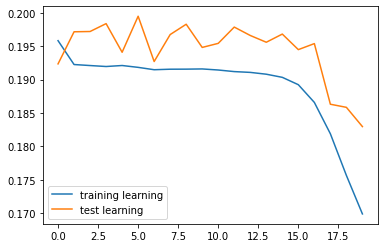

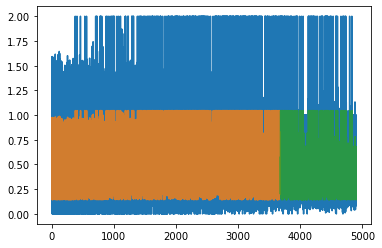

train MSE = 0.33
test MSE = 0.26


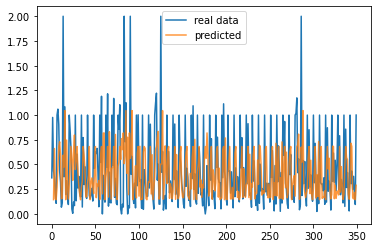

MSE = 0.16


In [23]:
# путь до файла с моделью
model_file = Path('model_BTC.h5')

# загружаем наши данные
df = df_all.copy()
df = df.drop(['Score'], axis=1)
take_n = 700
# делаем выборку данных для обучения и проверки
ds = np.array(df[:take_n]).reshape(-1, 1)
# в определенном виде
print(ds[:10])

# перенормируем данные
scl = MinMaxScaler(feature_range=(0, 1))
ds_scl = scl.fit_transform(ds)

# разделяем на две выборки: обучающую и для проверки
d_train, d_test = train_test_split(ds_scl, shuffle=False)
print(f'train_shape = {d_train.shape}, test_shape = {d_test.shape}')

# количество элементов по которым делается прогноз
lb = 1
# количество элементов для пропуска
skip_count = lb * 2
# приводим данные к виду который понимает нейронка
X_train, Y_train = rearrange(d_train, lb)
X_test, Y_test = rearrange(d_test, lb)
print(f'X_train_size = {X_train.shape}, Y_train_shape = {Y_train.shape}')

# проверка на существование файла 
if not model_file.exists():
    # создаём
    model = create_rnn()
    # обучаем
    fitted = model.fit(X_train, Y_train, epochs=20, batch_size=1, validation_data=(X_test, Y_test), verbose=2)
    # сохраняем чтобы каждый раз не обучать
    model.save(model_file)
    # смотрим как она обучалась на каждой эпохе
    plt.plot(fitted.history['loss'], label='training learning')
    plt.plot(fitted.history['val_loss'], label='test learning')
    plt.legend()
    plt.show()
else:
    # загружаем если есть обученная модель
    model = load_model(model_file)

# посмотрим как она справляется с прогнозом на тех же данных
x_train = X_train.reshape(X_train.shape[0])
x_test = X_test.reshape(X_test.shape[0])
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# возвращаем данным исходные границы изменения
y_pred_train = scl.inverse_transform(y_pred_train)
y_pred_test = scl.inverse_transform(y_pred_test)

# реальные значения x
x_real = np.arange(0, ds.shape[0], 1)
x_v_train, x_v_test = train_test_split(x_real, shuffle=False)
# и графики
plt.plot(x_real, ds, label='real data')
plt.plot(x_v_train[skip_count:], y_pred_train, label='train predict', alpha=0.8)
plt.plot(x_v_test[skip_count:], y_pred_test, label='test predict', alpha=0.8)
plt.show()

# делаем выборку исключая первые элементы
y_real_first = ds[skip_count:y_pred_train.size + skip_count]
y_real_second = ds[y_real_first.shape[0] + 2 * skip_count:]
# считаем ошибку прогнозирования используя MSE
print('train MSE = {:.2f}'.format(mean_squared_error(y_real_first, y_pred_train)))
print('test MSE = {:.2f}'.format(mean_squared_error(y_real_second, y_pred_test)))

take_m = 50
# подготовим новые данные
ds = np.array(df[take_n:take_n + take_m]).reshape(-1, 1)
ds_scl = scl.fit_transform(ds)
X_val, _ = rearrange(ds_scl, lb)
# произведём прогноз на новом блоке данных
Y_pred = model.predict(X_val)
# вернём нормальным вид данным
y_pred = scl.inverse_transform(Y_pred)
x_real = np.arange(0, ds.shape[0], 1)

# выводим графики
plt.plot(x_real, ds, label='real data')
plt.plot(x_real[skip_count:], y_pred, label='predicted', alpha=0.8)
plt.legend()
plt.show()

print('MSE = {:.2f}'.format(mean_squared_error(ds[skip_count:], y_pred)))

In [8]:
d = {'Метод': ["LinearRegression", "RandomForestRegressor", "KNeighborsRegressor", "SVR", "RNN" ], 'Метрика': ["R^2 = 0.751829", "R^2 =0.798619", "R^2 =0.798941","R^2 =0.748415", "MSE = 0.16"]}
df = pd.DataFrame(data=d)
df.head()  

,Метод,Метрика
0,LinearRegression,R^2 = 0.751829
1,RandomForestRegressor,R^2 =0.798619
2,KNeighborsRegressor,R^2 =0.798941
3,SVR,R^2 =0.748415
4,RNN,MSE = 0.16


Вывод: исходя из вычеслений, можно сделать вывод, что метод Случайный лес лучше описывает массив данных.
